In [31]:
import numpy as np
import pandas as pd
import pareto
import pareto_pic as paretop
import os
from itertools import chain
from matplotlib import pyplot as plt
import matplotlib.figure
import matplotlib.backends.backend_agg as agg

In [158]:
from platypus import (Solution, EpsilonBoxArchive, GenerationalDistance, InvertedGenerationalDistance,
                      Hypervolume, EpsilonIndicator, Spacing, Archive)
from hv3 import HyperVolume

In [2]:
# load solutions
sollist = []
solutions = []
for filename in os.listdir('data'):
    if filename.endswith('solution.csv'):
        sollist.append(filename[:-4])
        df_temp = pd.read_csv(f"data/{filename}", header=0)
        solutions.append(df_temp.values.tolist())
solutions = list(chain.from_iterable(solutions))
print(f"Loaded into list 'solutions': {', '.join(sollist)}")

Loaded into list 'solutions': SE_100_solution, SE_10_solution, SE_20_solution, SE_30_solution, SE_40_solution, SE_50_solution, SE_60_solution, SE_70_solution, SE_80_solution, SE_90_solution


In [6]:
data = pd.DataFrame(solutions)
data[4] = data[4] * -1
data

,0,1,2,3,4,5
0,-44.038378,-0.561524,-0.800938,-0.914562,0.253049,-1.000000
1,-27.386414,-0.813283,-0.858252,-0.887249,0.359346,-1.000000
2,-27.575046,-0.820097,-0.831958,-0.878031,0.358913,-1.000000
3,-29.039299,-0.677475,-0.459723,-0.402348,0.400741,-0.928571
4,-6.496087,-0.864246,-0.813427,-0.882157,0.456442,-0.964286
...,...,...,...,...,...,...
4863,-51.492356,-0.921575,-0.901841,-0.943381,0.225159,-0.857143
4864,-47.948453,-0.745190,-0.852494,-0.806604,0.271072,-0.928571
4865,-52.814913,-0.953202,-0.866339,-0.816118,0.203768,-0.964286
4866,-44.596640,-0.962645,-0.666324,-0.687213,0.302701,-0.821429


In [145]:
df_nondom

,0,1,2,3,4,5
0,-6.468815,-0.871547,-0.850627,-0.905223,0.455414,-0.928571
1,-51.464220,-0.864779,-0.290474,-0.718279,0.251212,-1.000000
2,-28.845284,-0.872557,-0.864409,-0.820928,0.400219,-0.928571
3,-44.532305,-0.588031,-0.854681,-0.861543,0.303793,-0.928571
4,-53.089074,-0.972258,-0.733871,-0.930338,0.203364,-0.964286
...,...,...,...,...,...,...
592,-15.863016,-0.270816,-0.853003,-0.907976,0.408197,-1.000000
593,-13.511944,-0.878709,-0.787492,-0.114047,0.450929,-0.964286
594,-38.875369,-0.488316,-0.894761,-0.874893,0.354183,-0.928571
595,-53.073450,-0.795815,-0.861570,-0.754765,0.221351,-1.000000


In [102]:
nondominated = pareto.eps_sort([solutions], [0,1,2,3,4,5], [0.5, 0.05, 0.05, 0.05, 0.05, 0.001], maximize=[4])
# archives = pareto.eps_sort(list(data.itertuples(False)), [0,1,2,3,4,5], [0.5, 0.05, 0.05, 0.05, 0.05, 0.001], maximize=[4])

<AxesSubplot:>

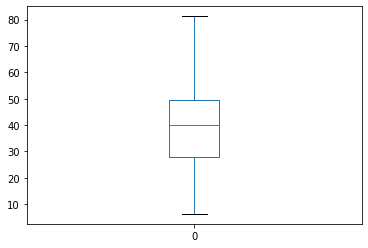

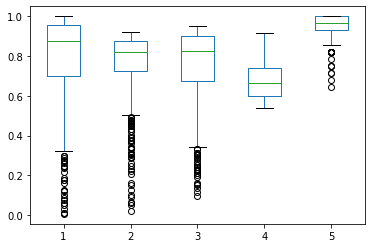

In [234]:
df_nondom = pd.DataFrame(nondominated)
df_nondom[[0,1,2,3,5]] = df_nondom[[0,1,2,3,5]] * -1
df_nondom[4] = 1 - df_nondom[4]
df_nondom[0].plot.box()
df_nondom[[1,2,3,4,5]].plot.box()

# fig, ax = plt.subplots()
# df_nondom[0].plot(kind='box', ax=ax)
# ax2 = ax.twinx()
# ax2.boxplot(df_nondom[[1,2,3,4,5]], positions=[2,3,4,5,6])
# ax2.set_xlim(0, 7)

In [243]:
df_plat = df_nondom * -1
print(df_plat.max())
print(df_plat.min())
results = df_plat.values.tolist()

0   -6.271250
1   -0.006196
2   -0.021139
3   -0.097578
4   -0.536961
5   -0.642857
dtype: float64
0   -81.273009
1    -0.998734
2    -0.918516
3    -0.951786
4    -0.914316
5    -1.000000
dtype: float64


In [178]:
class FixedLengthArray(object):

    def __init__(self, size, default_value = None, convert = None):
        super(FixedLengthArray, self).__init__()
        self._size = size
        if convert is not None:
            self._data = [convert(default_value) for _ in range(size)]
        else:
            self._data = [default_value]*size
        self.convert = convert
        
    def __len__(self):
        return self._size
        
    def __setitem__(self, index, value):
        if self.convert is not None:
            value = self.convert(value)
        
        if type(index) == slice:
            indices = range(*index.indices(self._size))
            
            if hasattr(value, "__len__") and len(value) == len(indices):
                for i, entry in enumerate(indices):
                    self._data[entry] = value[i]
            else:
                for entry in range(*index.indices(self._size)):
                    self._data[entry] = value    
        else:
            self._data[index] = value
            
    def __getitem__(self, index):
        return self._data[index]
    
    def __str__(self):
        return "[" + ", ".join(list(map(str, self._data))) + "]"

In [198]:
class Solution(object):
    """Class representing a solution to a problem.
    
    Attributes
    ----------
    problem: Problem
        The problem.
    variables: FixedLengthArray of objects
        The values of the variables.
    objectives: FixedLengthArray of float
        The values of the objectives.  These values will only be assigned after
        the solution is evaluated.
    constraints: FixedLengthArray of float
        The values of the constraints.  These values will only be assigned
        after the solution is evaluated.
    constraint_violation: float
        The magnitude of the constraint violation.
    """
    def __init__(self, ivars):
        """Creates a new solution for the given problem."""
        super(Solution, self).__init__()
#         self.problem = problem
        nvars = 32
        nobjs = 6
        nconstrs = 0
        self.ivars = ivars
        self.variables = FixedLengthArray(nvars)
        self.objectives = FixedLengthArray(nobjs)
        self.constraints = FixedLengthArray(nconstrs)
        self.constraint_violation = 0.0
        self.evaluated = False
        
    def evaluate(self):
        """Evaluates this solution."""
        self.problem(self)
        
    def __repr__(self):
        return self.__str__()
        
    def __str__(self):
        return "Solution[" + ",".join(list(map(str, self.ivars))) + "|" + ",".join(list(map(str, self.objectives))) + "|" + str(self.constraint_violation) + "]"
    
    def __deepcopy__(self, memo):
        """Overridden to avoid cloning the problem definition."""
        result = Solution(self.problem)
        memo[id(self)] = result
        
        for k, v in self.__dict__.items():
            if k != "problem":
                setattr(result, k, copy.deepcopy(v, memo))
                
        return result

In [250]:
df_plat = df_nondom * -1
refset = df_plat.values.tolist()

# def __str__(variables):
#     objectives = [ [] for _ in range(len(nondominated)) ]
#     constraint_violation = 0.0
#     return "Solution[" + ",".join(list(map(str, variables))) + "|" + ",".join(list(map(str, objectives))) + "|" + str(constraint_violation) + "]"

p_refset = Solution(nondominated)

# variables = FixedLengthArray(nondominated)
# platypus_refset = __str__(variables)
# platypus_refset = __str__(nondominated)
# platypus_refset
# # compute the indicators
# gd = GenerationalDistance(platypus_refset)
# print("Generational Distance:", gd.calculate())

# igd = InvertedGenerationalDistance(reference_set)
# print("Inverted Generational Distance:", igd.calculate(algorithm.result))

# hyp = Hypervolume(minimum=[-90, -1, -1, -1, -1, -1], maximum=[0, 0, 0, 0 ,0 ,0])
hyp = Hypervolume(p_refset)
# print("Hypervolume:", hyp.calculate(p_refset.variables))

# ei = EpsilonIndicator(reference_set)
# print("Epsilon Indicator:", ei.calculate(algorithm.result))

# sp = Spacing()
# print("Spacing:", sp.calculate(algorithm.result))

TypeError: 'Solution' object is not iterable

In [221]:
referencePoint = [2, 2, 2, 2, 2, 2]
hyperVolume = HyperVolume(referencePoint)
front = nondominated
result = hyperVolume.compute(front)
result

9193.639957111322

In [100]:
# data2 = pd.read_table("data/data.txt", header=None, sep=" ")
# # pareto.eps_sort(list(data2.itertuples(False)), [0,1], [resolution]*2)
# test = pareto.Archive([0.5, 0.05, 0.05, 0.05, 0.05, 0.001])
# sets[resolution].iloc[:, 3]

In [215]:
data = pd.DataFrame(solutions)
data[[0,1,2,3,5]] = data[[0,1,2,3,5]] * -1
data[4] = 1 - data[4]
print(data.max())
print(data.min())

0    81.273009
1     0.999840
2     0.918516
3     0.951786
4     0.917537
5     1.000000
dtype: float64
0    6.271250
1    0.004824
2    0.008694
3    0.004614
4    0.536961
5    0.642857
dtype: float64


In [213]:
# data = pd.read_table("data/SE_100_solution.csv", header=0, sep=",")
data = pd.DataFrame(solutions)
data[[0,1,2,3,5]] = data[[0,1,2,3,5]] * -1
data[4] = 1 - data[4]
sets = {}
archives = {}
fig = matplotlib.figure.Figure(figsize=(15,15))
agg.FigureCanvasAgg(fig)

resolutions = [1e-9, 0.03, 0.06, 0.1, 0.15, 0.2, 0.25, 0.4, 1.0] #[0.5, 0.05, 0.05, 0.05, 0.05, 0.001]  #[0.5, 0.05, 0.001] #[0.5, 0.05, 0.05, 0.05, 0.05, 0.001]
for resolution in resolutions:
    archives[resolution] = paretop.eps_sort([data.itertuples(False)], [1,3], [resolution]*6)
    sets[resolution] = pd.DataFrame(data=archives[resolution].archive)
counter = 0
for resolution in resolutions:
    counter += 1
    ax = fig.add_subplot(3, 3, counter)
    ax.scatter(data[0], data[1], lw=0, facecolor=(0.7, 0.7, 0.7), zorder=-1)
    ax.scatter(sets[resolution].iloc[:, 0], sets[resolution].iloc[:, 1], facecolor=(1.0, 1.0, 0.4), zorder=1, s=50)
    
    for box in archives[resolution].boxes:
        ll = [box[0] * resolution, box[1] * resolution]

        # make a rectangle in the Y direction
        rect = matplotlib.patches.Rectangle((ll[0], ll[1] + resolution), 1.4 - ll[0], 1.4 - ll[1], lw=0, facecolor=(1.0,0.8,0.8), zorder=-10)
        ax.add_patch(rect)

        # make a rectangle in the X direction
        rect = matplotlib.patches.Rectangle((ll[0] + resolution, ll[1]), 1.4 - ll[0], 1.4 - ll[1], lw=0, facecolor=(1.0,0.8,0.8), zorder=-10)
        ax.add_patch(rect)
        
    if resolution < 1e-3: # 
        spacing = 0.2
    else:
        spacing = resolution
        while spacing < 0.2:
            spacing *= 2

    ax.set_xticks(np.arange(0, 1.2, spacing))
    ax.set_yticks(np.arange(0, 1.2, spacing))
    
    if resolution > 0.001:
        ax.hlines(np.arange(0, 1.4, resolution), 0, 1.4, colors=(0.1, 0.1, 0.1, 0.1), zorder=2)
        ax.vlines(np.arange(0, 1.4, resolution), 0, 1.4, colors=(0.1, 0.1, 0.1, 0.1), zorder=2)
    ax.set_xlim(0, 1.2)
    ax.set_ylim(0, 1.2)
    ax.set_title("Epsilon resolution: {0:.2g}".format(resolution))
    ax.set_xlabel(r'$f_1$')
    ax.set_ylabel(r'$f_2$')
    
fig.subplots_adjust(wspace=0.3, hspace=0.3)
fig.savefig("figures/variety")

fig = matplotlib.figure.Figure(figsize=(5,5))
agg.FigureCanvasAgg(fig)
resolution = 0.06
sets[resolution] = pd.DataFrame(data=paretop.eps_sort([data.itertuples(False)], [0,1], [resolution]*2).archive)

ax = fig.add_subplot(1,1,1)
ax.scatter(data[0], data[1], lw=0, facecolor=(0.7, 0.7, 0.7), zorder=-1)
ax.scatter(sets[resolution].iloc[:, 0], sets[resolution].iloc[:,1], facecolor=(1.0, 1.0, 0.4), zorder=1, s=50)
for box in archives[resolution].boxes:
    ll = [box[0] * resolution, box[1] * resolution]

    # make a rectangle in the Y direction
    rect = matplotlib.patches.Rectangle((ll[0], ll[1] + resolution), 1.4 - ll[0], 1.4 - ll[1], lw=0, facecolor=(1.0,0.8,0.8), zorder=-10)
    ax.add_patch(rect)

    # make a rectangle in the X direction
    rect = matplotlib.patches.Rectangle((ll[0] + resolution, ll[1]), 1.4 - ll[0], 1.4 - ll[1], lw=0, facecolor=(1.0,0.8,0.8), zorder=-10)
    ax.add_patch(rect)
if resolution < 1e-3:
    spacing = 0.2
else:
    spacing = resolution
    while spacing < 0.2:
        spacing *= 2

ax.set_xticks(np.arange(0, 1.2, spacing))
ax.set_yticks(np.arange(0, 1.2, spacing))

if resolution > 0.001:
    ax.hlines(np.arange(0, 1.4, resolution), 0, 1.4, colors=(0.1, 0.1, 0.1, 0.1), zorder=2)
    ax.vlines(np.arange(0, 1.4, resolution), 0, 1.4, colors=(0.1, 0.1, 0.1, 0.1), zorder=2)
ax.set_xlim(0, 1.2)
ax.set_ylim(0, 1.2)
ax.set_title("Epsilon resolution: {0:.2g}".format(resolution))
ax.set_xlabel(r'$f_1$')
ax.set_ylabel(r'$f_2$')

fig.savefig("figures/example")
    

fig = matplotlib.figure.Figure(figsize=(5,5))
agg.FigureCanvasAgg(fig)

ax = fig.add_subplot(1,1,1)
ax.scatter(data[0], data[1], lw=0, facecolor=(0.7, 0.7, 0.7), zorder=-1)
spacing = 0.2
ax.set_xticks(np.arange(0, 1.2, spacing))
ax.set_yticks(np.arange(0, 1.2, spacing))
ax.set_xlim(0, 1.2)
ax.set_ylim(0, 1.2)
ax.set_title("Unsorted Data")
ax.set_xlabel(r'$f_1$')
ax.set_ylabel(r'$f_2$')

fig.savefig("figures/unsorted")

In [87]:
data2 = pd.read_table("exampledata.txt", header=None, sep=" ")
print(data2.max())
print(data2.min())

0    1.069411
1    1.144246
dtype: float64
0    0.122124
1    0.146022
dtype: float64


In [101]:
data = pd.read_table("exampledata.txt", header=None, sep=" ")
sets = {}
archives = {}

fig = matplotlib.figure.Figure(figsize=(15,15))
agg.FigureCanvasAgg(fig)

counter = 0

resolutions = [1e-9, 0.03, 0.06, 0.1, 0.15, 0.2, 0.25, 0.4, 1.0]
for resolution in resolutions:
    archives[resolution] = paretop.eps_sort([data.itertuples(False)], [0,1], [resolution]*2)
    sets[resolution] = pd.DataFrame(data=archives[resolution].archive)
    
for resolution in resolutions:
    counter += 1
    ax = fig.add_subplot(3,3,counter)
    ax.scatter(data[0], data[1], lw=0, facecolor=(0.7, 0.7, 0.7), zorder=-1)
    ax.scatter(sets[resolution].iloc[:,0], sets[resolution].iloc[:,1], facecolor=(1.0, 1.0, 0.4), zorder=1, s=50)

    for box in archives[resolution].boxes:
        ll = [box[0] * resolution, box[1] * resolution]

        # make a rectangle in the Y direction
        rect = matplotlib.patches.Rectangle((ll[0], ll[1] + resolution), 1.4 - ll[0], 1.4 - ll[1], lw=0, facecolor=(1.0,0.8,0.8), zorder=-10)
        ax.add_patch(rect)

        # make a rectangle in the X direction
        rect = matplotlib.patches.Rectangle((ll[0] + resolution, ll[1]), 1.4 - ll[0], 1.4 - ll[1], lw=0, facecolor=(1.0,0.8,0.8), zorder=-10)
        ax.add_patch(rect)

    if resolution < 1e-3:
        spacing = 0.2
    else:
        spacing = resolution
        while spacing < 0.2:
            spacing *= 2

    ax.set_xticks(np.arange(0, 1.2, spacing))
    ax.set_yticks(np.arange(0, 1.2, spacing))
    
    if resolution > 0.001:
        ax.hlines(np.arange(0, 1.4, resolution), 0, 1.4, colors=(0.1, 0.1, 0.1, 0.1), zorder=2)
        ax.vlines(np.arange(0, 1.4, resolution), 0, 1.4, colors=(0.1, 0.1, 0.1, 0.1), zorder=2)
    ax.set_xlim(0, 1.2)
    ax.set_ylim(0, 1.2)
    ax.set_title("Epsilon resolution: {0:.2g}".format(resolution))
    ax.set_xlabel(r'$f_1$')
    ax.set_ylabel(r'$f_2$')
                      
fig.subplots_adjust(wspace=0.3, hspace=0.3)
fig.savefig("variety")

fig = matplotlib.figure.Figure(figsize=(5,5))
agg.FigureCanvasAgg(fig)
resolution = 0.06
sets[resolution] = pd.DataFrame(data=paretop.eps_sort([data.itertuples(False)], [0,1], [resolution]*2).archive)

ax = fig.add_subplot(1,1,1)
ax.scatter(data[0], data[1], lw=0, facecolor=(0.7, 0.7, 0.7), zorder=-1)
ax.scatter(sets[resolution].iloc[:, 0], sets[resolution].iloc[:,1], facecolor=(1.0, 1.0, 0.4), zorder=1, s=50)
for box in archives[resolution].boxes:
    ll = [box[0] * resolution, box[1] * resolution]

    # make a rectangle in the Y direction
    rect = matplotlib.patches.Rectangle((ll[0], ll[1] + resolution), 1.4 - ll[0], 1.4 - ll[1], lw=0, facecolor=(1.0,0.8,0.8), zorder=-10)
    ax.add_patch(rect)

    # make a rectangle in the X direction
    rect = matplotlib.patches.Rectangle((ll[0] + resolution, ll[1]), 1.4 - ll[0], 1.4 - ll[1], lw=0, facecolor=(1.0,0.8,0.8), zorder=-10)
    ax.add_patch(rect)
if resolution < 1e-3:
    spacing = 0.2
else:
    spacing = resolution
    while spacing < 0.2:
        spacing *= 2

ax.set_xticks(np.arange(0, 1.2, spacing))
ax.set_yticks(np.arange(0, 1.2, spacing))

if resolution > 0.001:
    ax.hlines(np.arange(0, 1.4, resolution), 0, 1.4, colors=(0.1, 0.1, 0.1, 0.1), zorder=2)
    ax.vlines(np.arange(0, 1.4, resolution), 0, 1.4, colors=(0.1, 0.1, 0.1, 0.1), zorder=2)
ax.set_xlim(0, 1.2)
ax.set_ylim(0, 1.2)
ax.set_title("Epsilon resolution: {0:.2g}".format(resolution))
ax.set_xlabel(r'$f_1$')
ax.set_ylabel(r'$f_2$')

fig.savefig("example")
    

fig = matplotlib.figure.Figure(figsize=(5,5))
agg.FigureCanvasAgg(fig)

ax = fig.add_subplot(1,1,1)
ax.scatter(data[0], data[1], lw=0, facecolor=(0.7, 0.7, 0.7), zorder=-1)
spacing = 0.2
ax.set_xticks(np.arange(0, 1.2, spacing))
ax.set_yticks(np.arange(0, 1.2, spacing))
ax.set_xlim(0, 1.2)
ax.set_ylim(0, 1.2)
ax.set_title("Unsorted Data")
ax.set_xlabel(r'$f_1$')
ax.set_ylabel(r'$f_2$')

fig.savefig("unsorted")